In [2]:
import os
import sys
import glob
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import pickle
from IPython.display import display
import math
import seaborn as sns
from statistics import mean
import pprint

# Reading pymol log files:

This function extracts pymol log files in the directory to extract the RMSD of BCL-XL protein after alignment. The alignment and RMSD calculation are performed in pymol and the output log file for each protein complex contains the corresponding RMSD ($\mathring A$).

In [3]:
def readPymol_log(filename):

    rmsd_dict = {"rmsd": []}
    
    with open (filename) as log_file:
        
        lines = log_file.readlines()
        
        count = 0
        
        for line in lines:
            
            if "Executive: RMSD" in line:
                
                if count == 1:
                
                    rmsd = line.split (" ")[-5]
                
                    rmsd_dict["rmsd"].append(float(rmsd))
                
                count += 1
                
    return rmsd_dict

# Interface Energy Analyzer:

Reading the output file from ROSETTA InterfaceAnalyzer script. According to "In Silico Modeling of PROTAC-Mediated Ternary Complexes: Validation and Application (2019)", the protein-protein complexes with hydrophobic-interface area more than 100 $\mathring A$ can be used to filter docked conformations. In addition to the interface area metrics, interface score, binding free energy and custom ROSETTA packstat scores are also added for reference.

In [4]:
def readSASA(sasaFile):
    
    sasa_dict = {"INTERFACE_SCORE": [], "dG_GROSS": [], "dG_SEPARATED": [], "dSASA_HPHOBIC": [], "dSASA_POLAR": [], "dSASA_INT": [], "PACKSTAT": [], "PER_RESIDUE_ENERGY": []}
    
    with open(sasaFile) as fp:
        
        lineCount = 0
        
        Lines = fp.readlines()
        
        for line in Lines:
        
            if lineCount == 2:
                
                Dsasa=line.split()
            
            lineCount += 1
        
    sasa_dict["INTERFACE_SCORE"].append(float(Dsasa[1]))
    
    sasa_dict["dG_GROSS"].append(float(Dsasa[3]))
    
    sasa_dict["dG_SEPARATED"].append(float(Dsasa[5]))
    
    sasa_dict["dSASA_HPHOBIC"].append(float(Dsasa[7]))
    
    sasa_dict["dSASA_POLAR"].append(float(Dsasa[9]))
    
    sasa_dict["dSASA_INT"].append(float(Dsasa[8]))
    
    sasa_dict["PACKSTAT"].append(float(Dsasa[-12]))
    
    sasa_dict["PER_RESIDUE_ENERGY"].append(float(Dsasa[-11]))
        
    return sasa_dict

# Read ligand SDF file:

Read the provided ligand.sdf files for extracting the information regarding the binding affinity, RMSD of its components etc. Later, these data would be added to the dataframe.

In [5]:
def readLigand(ligand_file):
    
    ligand_dict = {"minimized_Affinity": [], "minimized_RMSD": [], "rmsd_Anchor": [], "rmsd_Warhead": []}
    
    with open(ligand_file) as fp:
        
        Lines = fp.readlines()
        
    ligand_dict["minimized_Affinity"].append(float(Lines[200]))
    
    ligand_dict["minimized_RMSD"].append(float(Lines[203]))
    
    ligand_dict["rmsd_Anchor"].append(float(Lines[206]))
    
    ligand_dict["rmsd_Warhead"].append(float(Lines[209]))
        
    return ligand_dict

# Interface Energy Breakdown

The interaction between the proteins are measured through the residue-wise interaction energy. Per-residue-energy may provide more insight into the quality of BCL-XL: VHL docking.

In [6]:
def readEnergyBreakdown(energyFile):    
    
    chain_A = str("VLRSVNSREPSQVIFCNRSPRVVLPVWLNFDGEPQPYPTLPPGTGRRIHSYRGHLWLFRDAGTHDGLLVNQTELFVPSLNVDGQPIFANITLPVYTLKERCLQVVRSLVKPENYRRLDIVRSLYEDLEDHPNVQKDLERLTQER")

    chain_Z = str("SQSNRELVVDFLSYKLSQKGYGMAAVKQALREAGDEFELRYRRAFSDLTSQLHITPGTAYQSFEQVVNELFRDGVNWGRIVAFFSFGGALCVESVDKKMQVLVSRIAAWMATYLNDHLEPWIQENGGWATFVELYG")
        
    len_of_chain_A = len(chain_A)
    
    len_of_chain_Z = len(chain_Z)
      
    with open(energyFile) as fp:
        
        Lines = fp.readlines()
        
        peptideLength = int(Lines[-1].split()[6][:-1])
    
    energy_dict = {"Residue_Pairs": [[[0] * len_of_chain_Z for i in range(len_of_chain_A)]*1], "Energy_of_pairs": [[[0] * len_of_chain_Z for i in range(len_of_chain_A)]*1], "Peptide_Residues": [peptideLength*[0]], "Energy_pepRes": [peptideLength*[0]]}
    
    with open(energyFile) as fp:
        
        Lines = fp.readlines()
        
        for line in Lines:
            
            if line.split()[7] != "onebody" and line.split()[7] != "restype2":
                
                chain1 = line.split()[3]
                
                chain2 = line.split()[6]
                
                energy = line.split()[-2]
                
                if chain1[-1] != chain2[-1]:
                    
                    residue_pair = "{}-{}".format(chain1, chain2)
                    
                    energy_dict["Energy_of_pairs"][0][int(chain1[:-1])-1][int(chain2[:-1])-len_of_chain_A-1] = (float(energy))
                        
                    energy_dict["Peptide_Residues"][0][int(chain2[:-1])-1] = line.split()[7]
                        
                    energy_dict["Energy_pepRes"][0][int(chain2[:-1])-1] += float(energy)
                                         
    return energy_dict    

# Protein Docking Score:

BCL-XL:VHL docked conformation rescoring according to DFIRE2 force field. DFIRE2 scoring function is based on the stochastic information regarding residue-residue interactions from known protein-protein interactions.

In [7]:
def readLDScore(scoreFile):
    
    score_fn = ((scoreFile.split("/")[-1]).split("_")[1]).split(".")[0]
    
    score_key = "score_{}".format(score_fn)
    
    score_dict = {score_key: []}
    
    with open(scoreFile) as fp: 
        
        lineCount = 0
        
        Lines = fp.readlines()
        
        for line in Lines:
            
            score_dict[score_key].append(float(line.rstrip()))
            
            lineCount += 1
            
    score_dict[score_key] = score_dict[score_key][:25]
            
    return score_dict 

# Correlation Matrix:

The correlation between two separate measures are computed below. This correlation would help us understand how to filter the structures. 

In [8]:
def correlationArrayfromDF(dataFrame, correlation_base):
    
    correlation_array = []
    
    column_index = 0
    
    for column in dataFrame:
        
        data_1 = (dataFrame[column]).tolist()
        
        data_2 = (dataFrame[correlation_base]).tolist()
        
        [float(i) for i in data_1]
        
        [float(i) for i in data_2]
   
        corr, _ = pearsonr(data_1, data_2)
    
        correlation_array.append(corr)
        
    return correlation_array

# Enrichment Factor:

This function computes the enrichment factor based on the RMSD values. Later, applies a custom filter to the dataframe such that the enrichment factor improves for the filtered dataset. 

In [9]:
def enrichmentFactor (DataFrame, filtered_DataFrame):
    
    base_EF = (DataFrame[DataFrame["rmsd"] <= 10].shape[0])/DataFrame.shape[0]
    
    print(base_EF)
    
    filtered_DataFrame_RMSD = filtered_DataFrame[filtered_DataFrame["rmsd"] <= 10]
    
    improv_EF = (filtered_DataFrame_RMSD.shape[0])/filtered_DataFrame.shape[0]

    print(improv_EF)
    
    EF_improv_fraction = improv_EF/base_EF
    
    return improv_EF

In [10]:
if __name__ == "__main__":

    path= './6ZHC_design/'

    if path[-1] == "/":
        pass
    
    else:
       
        path = path + "/"

    all_folders = os.listdir(path)

    new_folders = []

    for f in all_folders:
        fold = path + f
        if os.path.isdir(fold) :
            new_folders.append(f)
        
    new_folders.sort()

    list_of_pdbs = []
    
    for folderName in new_folders:
    
        wholePath = path + folderName
    
        outFile = path + "rosetta_relaxed_scoring.csv"
    
        info_dict = {"PDB": [], "INTERFACE_SCORE": [], "dG_GROSS": [], "dG_SEPARATED": [], "dSASA_HPHOBIC": [], "dSASA_POLAR": [], "dSASA_INT": [], "PACKSTAT": [], "PER_RESIDUE_ENERGY": [], "PROTEIN_PEPTIDE_INTER_RESIDUE_PAIRS": [], "TOTAL_INT_ENERGY": []}
    
        scoreFile = wholePath + "/" + "relaxed_per_residue.out"
        
        sasaFile = scoreFile.replace("relaxed_per_residue.out", "pack_score.sc")
        
        pdb_dict = {"PDB": []}
        
        pdb_dict["PDB"] = folderName + "_AZ_relaxed_0001.pdb"
        
        pymol_logfile = wholePath + "/" + folderName + "_rmsd.log"
        
        ligand_file = wholePath + "/" + folderName[:-3] + "ligand.sdf"
        
        RMSD_dict = readPymol_log(pymol_logfile)
        
        ligand_dict = readLigand(ligand_file)
 
        dsasa_dict  = readSASA(sasaFile)

        energy_dict = readEnergyBreakdown(scoreFile)
        
        complex_dict = {**pdb_dict, **RMSD_dict, **ligand_dict, **dsasa_dict, **energy_dict}
        
        complex_Results = pd.DataFrame.from_dict(complex_dict)
        
        list_of_pdbs.append(complex_Results)
        
        allPDBs = pd.concat(list_of_pdbs, ignore_index=True)
    
    fig, axs = plt.subplots(3, 4, figsize=(30,15))

    axs[0, 0].plot(allPDBs.index, allPDBs["INTERFACE_SCORE"])
    axs[0, 0].set_title("INTERFACE_SCORE")
    axs[0, 1].plot(allPDBs.index, allPDBs["dG_GROSS"], 'tab:orange')
    axs[0, 1].set_title("dG_GROSS")
    axs[0, 2].plot(allPDBs.index, allPDBs["dG_SEPARATED"], 'tab:green')
    axs[0, 2].set_title("dG_SEPERATED")
    axs[0, 3].plot(allPDBs.index, allPDBs["dSASA_HPHOBIC"], 'tab:red')
    axs[0, 3].set_title("dSASA_HPHOBIC")
    axs[1, 0].plot(allPDBs.index, allPDBs["dSASA_POLAR"])
    axs[1, 0].set_title("dSASA_POLAR")
    axs[1, 1].plot(allPDBs.index, allPDBs["dSASA_INT"], 'tab:orange')
    axs[1, 1].set_title("dSASA_INT")
    axs[1, 2].plot(allPDBs.index, allPDBs["PACKSTAT"], 'tab:green')
    axs[1, 2].set_title("PACKSTAT")
    axs[1, 3].plot(allPDBs.index, allPDBs["PER_RESIDUE_ENERGY"], 'tab:red')
    axs[1, 3].set_title("PER_RESIDUE_ENERGY")
    axs[2, 2].plot(allPDBs.index, allPDBs["rmsd"], 'tab:green')
    axs[2, 2].set_title("rmsd")

    fig.savefig(path+ "rosetta_relaxed_scoring.png")
    plt.close()
        
    correlationMatrix = []

    for folder in range(len(new_folders)):
    
        dataFrame_corr = allPDBs[["rmsd", "minimized_Affinity", "minimized_RMSD", "rmsd_Anchor", "rmsd_Warhead", "INTERFACE_SCORE", "dG_GROSS", "dG_SEPARATED", "dSASA_HPHOBIC", "dSASA_POLAR", "dSASA_INT", "PER_RESIDUE_ENERGY",]]#, "score_dfire2"]]
    
        correlationArray = correlationArrayfromDF(dataFrame_corr, "rmsd")
    
        correlationMatrix.append(correlationArray)
    
    correlationMatrix = np.array(correlationMatrix)
    
    correlationMatrix_mean = np.zeros(correlationMatrix.shape[1])

    for column in range(correlationMatrix.shape[1]):
    
        correlationMatrix_mean[column] = np.mean(correlationMatrix[:, column])
    
    correlationMatrix_mean


Mean Pearson' Correlation between RMSD values and other metrics are computed here. It can be shown that the correlation between solvent accessible surface area metrics are in better correlation (~0.4) than any other measure. However, they are positively correlated. Ideally, they should be negatively correlated meaning that with decrease in RMSD values, SASA should go up. However, in our case, these two parameters are positivel correlated suggesting that RMSD values of favorable structures have less SASA than other structures. 

In [11]:
correlationMatrix_mean

array([ 1.        ,  0.19041256,  0.01224258, -0.21900591,  0.10654842,
       -0.21057158, -0.41127819, -0.40916932,  0.35558737,  0.48940431,
        0.44652791, -0.03584946])

Plotting of minimized affinity histogram for all PDB structures suggested that systems with lowest affinity (stronger attinity) are more stable than other structures and they potentially have the least RMSD. furthermore, target protein-E3 ligase activity is highly dependent on the PROTAC molecule and its binding itself. Therefore, some measure of the binding affinity of the PROTAC molecule to the protein complex would be useful in filtering these structures. As these values were provided by vantAI, I chose them to filter the structures. 

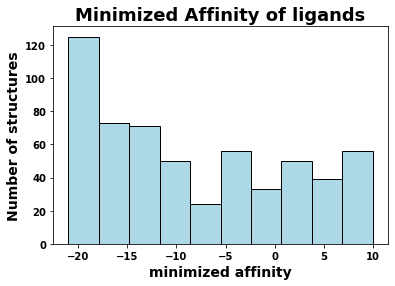

In [12]:
allPDBs_affinity = allPDBs[allPDBs["minimized_Affinity"] <= -18]

allPDBs_affinity.sort_values(by = "rmsd", ascending = True).reset_index(drop=True)

plt.hist(allPDBs["minimized_Affinity"].to_list(), color = "lightblue", ec = "black")

plt.xlabel("minimized affinity", fontweight='bold', fontsize='14')

plt.ylabel("Number of structures", fontweight='bold', fontsize='14')

plt.title("Minimized Affinity of ligands", fontweight='bold', fontsize='18')

plt.xticks(fontweight='bold')

plt.yticks(fontweight='bold')

plt.savefig('minimized_affinity.png')

# Initial filtering of the structures to improve the Enrichment Factor:

The structures with lowest minimized affinity and polar solvent accessible surface area were filtered. The improvement in the Enrichment Factor was only minimal. I chose the maximum polar solvent accessible surface area at the interface (dSASA_POLAR) to be 250 $\mathring A$ and maximum minimized affinity of the ligand to be -18. Our filtering yielded a minimial increase in the EF to 0.3. However, only 10 structures with lower than 10 $\mathring A$ RMSD were identified.

In [13]:
filtered_allPDBs = allPDBs[(allPDBs["dSASA_POLAR"] <=(250)) & (allPDBs["dSASA_POLAR"] >=(100)) & (allPDBs["minimized_Affinity"] <=(-18))]

print("filtered_allPDBs: {0}".format(filtered_allPDBs.shape[0]))

filtered_allPDBs_RMSD = filtered_allPDBs[filtered_allPDBs["rmsd"] <= 10]

print("filtered_allPDBs_RMSD: {0}".format(filtered_allPDBs_RMSD.shape[0]))

Enrichment_Factor = filtered_allPDBs_RMSD.shape[0]/filtered_allPDBs.shape[0]

print("Enrichment Factor: {0}".format(Enrichment_Factor))

filtered_allPDBs: 10
filtered_allPDBs_RMSD: 3
Enrichment Factor: 0.3


In [29]:
allPDBs = (allPDBs.sort_values(by = "rmsd", ascending = True)).reset_index(drop=True)

with open('allPDBs_DF.pickle', 'wb') as f:
    pickle.dump(allPDBs, f)

allPDBs

,PDB,rmsd,minimized_Affinity,minimized_RMSD,rmsd_Anchor,rmsd_Warhead,INTERFACE_SCORE,dG_GROSS,dG_SEPARATED,dSASA_HPHOBIC,dSASA_POLAR,dSASA_INT,PACKSTAT,PER_RESIDUE_ENERGY,Residue_Pairs,Energy_of_pairs,Peptide_Residues,Energy_pepRes
0,19_183_PPI_AZ_relaxed_0001.pdb,2.794,-19.095329,1.34545,1.191492,0.720996,-859.552,-14.109,-10.956,350.410,307.614,658.025,0.631,-2.271,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,19_125_PPI_AZ_relaxed_0001.pdb,2.845,-18.300680,1.35829,1.128998,1.004177,-857.835,-13.888,-12.812,450.230,263.619,713.849,0.639,-2.306,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,19_286_PPI_AZ_relaxed_0001.pdb,2.903,-18.892799,1.29918,1.086905,0.815252,-852.879,-8.566,-8.086,282.775,410.239,693.013,0.654,-1.552,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,19_167_PPI_AZ_relaxed_0001.pdb,2.977,-18.336229,1.23092,1.218042,0.957737,-843.868,-7.741,-7.625,245.456,151.480,396.935,0.609,-1.213,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,19_127_PPI_AZ_relaxed_0001.pdb,3.026,-18.802540,1.35106,1.130375,0.837535,-850.826,-7.796,-7.575,206.425,237.125,443.551,0.528,-2.420,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
572,28_249_PPI_AZ_relaxed_0001.pdb,30.254,-16.826031,1.46581,0.271923,0.905120,-866.629,-30.138,-28.049,679.488,444.257,1123.745,0.662,-3.296,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
573,2_298_PPI_AZ_relaxed_0001.pdb,32.306,-19.766911,1.87319,0.624556,0.406506,-847.957,-8.663,-8.166,259.880,307.975,567.855,0.634,-2.318,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
574,28_36_PPI_AZ_relaxed_0001.pdb,34.304,-0.395590,3.17183,1.406865,0.770759,-847.637,-19.907,-17.489,586.513,447.777,1034.290,0.574,-2.774,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
575,28_175_PPI_AZ_relaxed_0001.pdb,34.306,-14.895400,2.56315,0.276635,0.517792,-854.305,-19.311,-16.164,573.010,434.786,1007.796,0.670,-2.730,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
vertical_axis = math.ceil(allPDBs.shape[0]/3)

fig, axs = plt.subplots(vertical_axis, 3, figsize=(30,45))

fig.tight_layout()

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

for seq in range(allPDBs.shape[0]):
    
    row = (seq//3)
    
    column = seq%3
    
    axs[row, column].bar(list(range(1,len(peptide_sequence)+1)), allPDBs["avgResidueEnergy"][seq])
    
    axs[row, column].set_xticks(range(1, len(avgResidueEnergyDF["peptideSequence"][seq])+1), list(avgResidueEnergyDF["peptideSequence"][seq]))
    
    axs[row, column].set_title(avgResidueEnergyDF["ID"][seq])
    
    axs[row, column].set_xlabel("Peptide Residues", fontsize=18)
    
    axs[row, column].set_ylabel("Fractional energy", fontsize=18)
    
fig.savefig(path + '/' + "peptideResidueEnergy.png")

In [16]:

chain_A = str("VLRSVNSREPSQVIFCNRSPRVVLPVWLNFDGEPQPYPTLPPGTGRRIHSYRGHLWLFRDAGTHDGLLVNQTELFVPSLNVDGQPIFANITLPVYTLKERCLQVVRSLVKPENYRRLDIVRSLYEDLEDHPNVQKDLERLTQER")

chain_Z = str("SQSNRELVVDFLSYKLSQKGYGMAAVKQALREAGDEFELRYRRAFSDLTSQLHITPGTAYQSFEQVVNELFRDGVNWGRIVAFFSFGGALCVESVDKKMQVLVSRIAAWMATYLNDHLEPWIQENGGWATFVELYG")

136

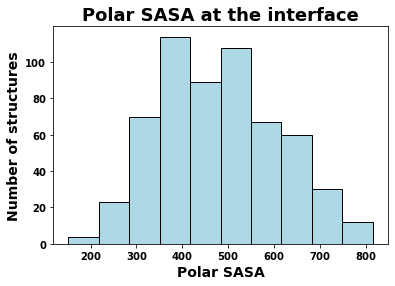

In [18]:
plt.hist(allPDBs['dSASA_POLAR'].tolist(), color = "lightblue", ec = "black")

plt.xlabel("Polar SASA", fontweight='bold', fontsize='14')

plt.ylabel("Number of structures", fontweight='bold', fontsize='14')

plt.title("Polar SASA at the interface", fontweight='bold', fontsize='18')

plt.xticks(fontweight='bold')

plt.yticks(fontweight='bold')

plt.savefig('dSASA_POLAR.png')

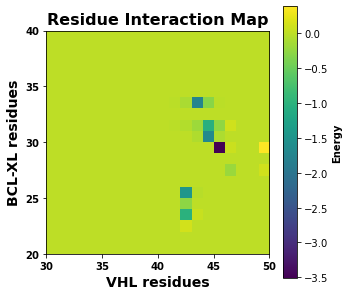

In [19]:
fig, ax = plt.subplots(1,1)

fig.set_size_inches(5, 5)

Interaction_Energy_Array = np.array(allPDBs["Energy_of_pairs"][0])

img = ax.imshow(Interaction_Energy_Array[20:40, 30:50],extent=[20, 40, 30, 50])

x_label_list = ['30', '35', '40', '45', '50']
y_label_list = ['20', '25', '30', '35', '40']

ax.set_xticks([20, 25, 30, 35, 40])
ax.set_yticks([30, 35, 40, 45, 50])

ax.set_xticklabels(x_label_list, fontweight="bold")
ax.set_yticklabels(y_label_list, fontweight="bold")

ax.set_xlabel ("VHL residues", fontweight="bold", fontsize="14")

ax.set_ylabel ("BCL-XL residues", fontweight="bold", fontsize="14")

ax.set_title("Residue Interaction Map",  fontweight="bold", fontsize="16")

cbar = fig.colorbar(img)

cbar.set_label("Energy", fontweight="bold")

plt.savefig('Residue_Interaction_Energy.png')

In [22]:
energy_pairs_affinity = np.array(list(allPDBs[allPDBs["PDB"] == '16_245_PPI_AZ_relaxed_0001.pdb']["Energy_of_pairs"]))

Affinity_non_zero_elements = np.nonzero(energy_pairs_affinity[0])

Affinity_nonzero_row = Affinity_non_zero_elements[0]

Affinity_nonzero_col = Affinity_non_zero_elements[1]

residue_pair_Affinity = []

for i in range(len(Affinity_nonzero_row)):
    
    residue_pair_Affinity.append("{0}-{1}".format(Affinity_nonzero_row[i],Affinity_nonzero_col[i]))

In [23]:
residue_pair_Affinity

['2-72',
 '5-74',
 '5-75',
 '5-76',
 '5-120',
 '7-74',
 '7-75',
 '7-120',
 '7-123',
 '7-124',
 '26-44',
 '27-44',
 '28-44',
 '28-75',
 '28-77',
 '28-78',
 '29-72',
 '29-75',
 '29-76',
 '29-77',
 '29-78',
 '30-44',
 '30-68',
 '30-69',
 '30-72',
 '30-78',
 '31-72',
 '32-43',
 '32-44',
 '32-45',
 '32-78',
 '33-43',
 '33-44',
 '34-39',
 '34-40',
 '34-41',
 '34-43',
 '34-44',
 '35-42',
 '35-43',
 '36-40',
 '50-133']

In [24]:
for i in range(len(residue_pair_Affinity)):
        
    energy_pair_Affinity_list = list(allPDBs[allPDBs["PDB"] == '16_245_PPI_AZ_relaxed_0001.pdb']["Energy_of_pairs"])
        
    row_index = int(residue_pair_Affinity[i].split('-')[0])
        
    col_index = int(residue_pair_Affinity[i].split('-')[1])
        
    print(residue_pair_Affinity[i], energy_pair_Affinity_list[0][row_index][col_index])

2-72 -0.259
5-74 -0.098
5-75 -0.041
5-76 0.025
5-120 0.014
7-74 -0.022
7-75 0.021
7-120 -0.075
7-123 -0.004
7-124 -1.634
26-44 -0.353
27-44 -0.001
28-44 -0.564
28-75 -0.01
28-77 0.004
28-78 0.18
29-72 0.191
29-75 -0.906
29-76 0.014
29-77 0.028
29-78 0.004
30-44 -0.006
30-68 0.26
30-69 0.006
30-72 -0.264
30-78 -0.172
31-72 0.02
32-43 0.379
32-44 -3.039
32-45 -4.547
32-78 -0.111
33-43 0.685
33-44 -0.417
34-39 0.065
34-40 -1.129
34-41 0.003
34-43 -1.485
34-44 -1.199
35-42 -0.003
35-43 -0.775
36-40 -0.138
50-133 -0.002


In [25]:
filtered_allPDBs = pd.DataFrame([])

for index, row in allPDBs.iterrows():
    
#     if (row['Energy_of_pairs'][28][44] !=0) | (row['Energy_of_pairs'][34][43] != 0) | (row['Energy_of_pairs'][26][44] != 0):
         
    if (row['Energy_of_pairs'][32][45] !=0 ) :
    
        filtered_allPDBs = filtered_allPDBs.append(row)


/tmp/ipykernel_1249413/3906547236.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_allPDBs = filtered_allPDBs.append(row)
/tmp/ipykernel_1249413/3906547236.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_allPDBs = filtered_allPDBs.append(row)
/tmp/ipykernel_1249413/3906547236.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_allPDBs = filtered_allPDBs.append(row)
/tmp/ipykernel_1249413/3906547236.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_allPDBs = filtered_allPDBs.append(row)
/tmp/ipykernel_1249413/3906547236.py:9: FutureWarning: The frame.append method is deprecated and will be rem

/tmp/ipykernel_1249413/3906547236.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_allPDBs = filtered_allPDBs.append(row)
/tmp/ipykernel_1249413/3906547236.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_allPDBs = filtered_allPDBs.append(row)
/tmp/ipykernel_1249413/3906547236.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_allPDBs = filtered_allPDBs.append(row)
/tmp/ipykernel_1249413/3906547236.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_allPDBs = filtered_allPDBs.append(row)
/tmp/ipykernel_1249413/3906547236.py:9: FutureWarning: The frame.append method is deprecated and will be rem

In [26]:
improv_EF = (filtered_allPDBs[filtered_allPDBs["rmsd"] <=10].shape[0])/filtered_allPDBs.shape[0]

print("Number of structures with RMSD less than 10 angstrom is: ", filtered_allPDBs[filtered_allPDBs["rmsd"] <=10].shape[0])
print("Total number of structures in the filtered list: ", filtered_allPDBs.shape[0])
print("Improved Enrichment Factor is: ", improv_EF)


Number of structures with RMSD less than 10 angstrom is:  41
Total number of structures in the filtered list:  59
Improved Enrichment Factor is:  0.6949152542372882


In [28]:
with open('allPDBs_filtered_DF.pickle', 'wb') as f:
    pickle.dump(filtered_allPDBs, f)

filtered_allPDBs